In [1]:
from monai.utils import first
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    ToTensord,
    ScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    Flipd,
    RandAffined,
)


from monai.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import os
import torch
import nibabel as nib
from tqdm import tqdm

In [ ]:
def save_nifti(in_image, in_label, out, index = 0):
    # Convert the torch tensors into numpy array
    volume = np.array(in_image.detach().cpu()[0, :, :, :], dtype=np.float32)
    lab = np.array(in_label.detach().cpu()[0, :, :, :], dtype=np.float32)
    
    # Convert the numpy array into nifti file
    volume = nib.Nifti1Image(volume, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))
    
    # Create the path to save the images and labels
    path_out_images = os.path.join(out, 'Images')
    path_out_labels = os.path.join(out, 'Labels')
    
    # Make directory if not existing
    if not os.path.exists(path_out_images):
        os.mkdir(path_out_images)
    if not os.path.exists(path_out_labels):
        os.mkdir(path_out_labels)
    
    path_data = os.path.join(out, 'Images')
    path_label = os.path.join(out, 'Labels')
    nib.save(volume, os.path.join(path_data, f'patient_generated_{index}.nii.gz'))
    nib.save(lab, os.path.join(path_label, f'patient_generated_{index}.nii.gz'))

    print(f'patient_generated_{index} is saved', end='\r')

In [2]:
data_dir = 'D:/3_Stage/ALL_THE_DATA/fixed_data_03_august/all_together'
train_images = sorted(glob.glob(os.path.join(data_dir, "TrainData", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "TrainLabels", "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

In [3]:
original_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,), 
        ToTensord(keys=["image", "label"]),
    ]
)

In [9]:
generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,), 
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

In [10]:
original_ds = Dataset(data=train_files, transform=original_transforms)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

_______________________________________________________________________________________________________

# Display the original patient and the generated one

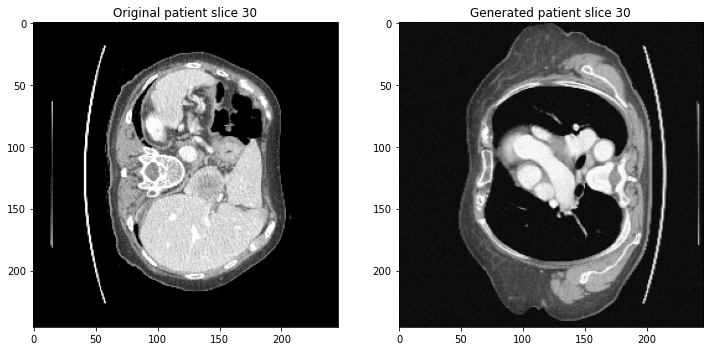

In [11]:
number_slice = 30
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")


plt.show()

_______________________________________________________________________________________________________

# Save the generated patients
The variable 'number_runs' will control how many time you will multiply your data.

In [ ]:
output_path = 'D:/3_Stage/ALL_THE_DATA/generated_data'
number_runs = 10
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    check_ds = Dataset(data=train_files, transform=generat_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader)
    for index, patient in enumerate(check_loader):
        save_nifti(patient['image'], patient['label'], output, index)
    print(f'step {i} done')